**Cosmic Ray Identification**

In this notebook, we will be exploring different techniques for identifying cosmic rays in the full 2D echelle specturm prior to reduction. The reason for this is that the strategy in the APF tutorial attempts to identify cosmic rays after reduction, which could potentially confuse cosmic rays for candidate signals. Therefore, we are looking at the raw data spectrum in order to identify cosmic rays before tampering with the data. This should allow for efficient cosmic ray identification and should prevent the removal of candidate laser signals.

**Gaussian Curve Fit**

When light (including any laser signals) enters the optics, it is spread out according to the point spread function. The light is spread out into a curve closely resembling a gaussian. Cosmic rays however deposit energy into the spectrum randomly and do not get spread out by the point spread function, therefore not appearing as gaussian.

In our algorithm, we cycle through an order in the spectral direction and attempt to fit 1-D spatial slices of the spectrum to gaussian curves. We take the reduced-chi squared number for each 1-D slice to see how well it fit the gaussian curve. If the reduced chi-squared number was low enough, we would determine that patch as being free of cosmic rays. However, if the reduced chi-squared number was abnormally large, we would assume that the patch contained a cosmic ray. This is due to the fact that a cosmic ray would not appear gaussian as it is randomly deposited energy. This strategy is effective, yet also requires heavy computing power, as it involves fitting thousands of patches to gaussian curves.

One of the problems with this approach is that there are very few pixels across each one pixel slice of the order. Even patches that visually appear gaussian thus have relatively high reduced chi-squared nubmers. This forced us to pick rather arbitrary limits for the chi-squared numbers and therefore was somewhat unreliable.

**A Potentially More Efficient Approach**

The next strategy we approached was much faster and more effecient. It involves cycling through an order in the same way and checking one pixel wide patches along the order to see if they are symmetrical. We'd expect for the point spread function to be symmetrical around the peak, and therefore if there was a cosmic ray, thed distribution would be asymmetrical. This doesn't account for a cosmic ray hitting directly at the peak, but we can easily extend the model to account for this. 

In this strategy, we divide each one pixel wide patch into two halves and take the average value of each of those halves. We then take the absolute value of the ratio of the two averages. If the difference is greater than a predetermined limit, we flag that slice of the order as containing a cosmic ray, as a large difference between the averages means the patch was asymmetrical.

This algorithm was much more efficient to run than the gaussian fit, as it required much less computing power.

In [64]:
%matplotlib inline

import numpy as np
import astropy.io.fits as pf
# import pyfits as pf
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import Image
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

import lmfit
from lmfit import minimize, Parameters, report_fit, fit_report
from lmfit.models import GaussianModel

In [65]:
#Import fits file and rotate and flip into appropriate X,Y configuration

apf_file = pf.open('ucb-amp194.fits')
image = apf_file[0].data
image_rot = np.rot90(image)
image_flip = np.fliplr(image_rot)
bias = np.median(image_flip[-30:])

**Gaussian Fit in Spatial Direction**

We start by defining a function that takes a one pixel (in the spectral direction) slice of the spectrum and checks to see if the intensity values fit a gaussian distribution.

In [66]:
# x1 is the pixel in the spectral dimension
# a slice is taken between y1 and y2 to evaluate

def check_fit(x1,y1,y2):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(image_flip[y1:y2,x1:x1+1], cmap = 'gray', interpolation = 'nearest',
               vmin = np.median(image), vmax = np.median(image) *1.2, origin = 'lower')
    
    slice = np.arange(0,y2-y1+1)
    for i in range (y2-y1+1):
        slice[i] = image_flip[y1+i,x1]

    slice = slice - bias
    
    x = np.arange(0,y2-y1+1)
    mod = GaussianModel()
    pars = mod.guess(slice,x=x)
    out = mod.fit(slice, pars, x=x)
     
    plt.subplot(1,2,2)
    plt.plot(x, slice, color='b', marker ='o')
    plt.plot(x, out.best_fit, color = 'g', marker = 'x')
    plt.title('Reduced Chi Squared:  ' + str(out.redchi))

The following slice visually appears not to contain a cosmic ray and the chart of the gaussian model against the distribution looks very close. However, it still has a high reduced chi-squared number given the small sample size.

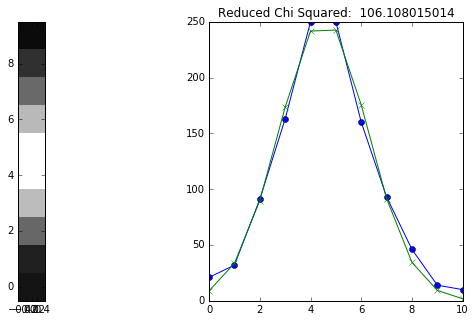

In [67]:
check_fit(2735,1555,1565)

The following is a one pixel wide slice taken from a section of a spectrum that clearly contains a cosmic ray. As can be seen below, the curve of the intensities is completely non-gaussian and the reduced chi-squared number is enormous.

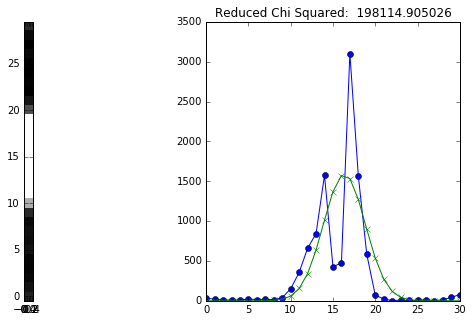

In [68]:
check_fit(2773,1545,1575)

The following function uses the same logic as the previous function but is extended to cycle through a range of x values in the spectral direction to identify cosmic rays, which are then marked visually on the 2D spectrum.

In [69]:
def find_fit(x1, x2, y1, y2, lim):
    
    chisq_results = np.arange(0, x2-x1+1)
    
    for j in range(x2-x1+1):
        slice = np.arange(0,y2-y1+1)
        for i in range (y2-y1+1):
            slice[i] = image_flip[y1+i,x1+j]

        slice = slice - bias
        
        x = np.arange(0,y2-y1+1)
        mod = GaussianModel()
        pars = mod.guess(slice,x=x)
        out = mod.fit(slice, pars, x=x)
        chisq_results[j] = out.redchi
                 
    plt.figure(figsize = (5,10))        
    plt.subplot(2,1,1) 
    plt.plot(chisq_results, color = 'b')
    plt.title("Reduced Chi Squared Values")
    
    plt.subplot(2,1,2)
    plt.imshow(image_flip[y1:y2, x1:x2], cmap = 'gray', aspect = 'auto', interpolation = 'nearest',
               vmin = np.median(image), vmax = np.median(image) *1.2, origin = 'lower')
    
    for i in range(x2-x1+1):
        if chisq_results[i] > lim:
            plt.axvline(x=i, color = 'r')

The previous function was then run over a patch with a known cosmic ray, and identified it, as can be seen below.

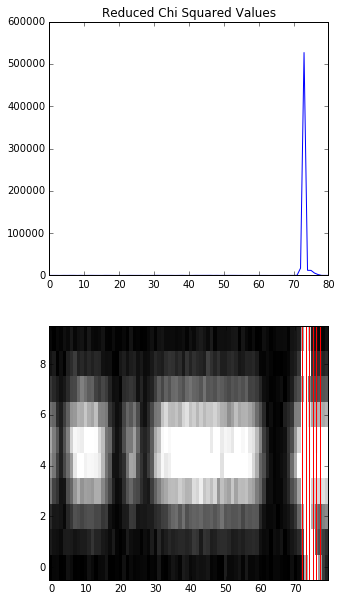

In [70]:
find_fit(2700, 2780, 1555, 1565, 800)

**Simpler Test for Symmetry to Identify Cosmic Rays**

The following is a faster, more efficient algorithm to identify and remove cosmic rays. It involves looping through an order in the spatial direction and determining if each one pixel slice is symmetric or not. If it is not symmetric, this means there is likely no cosmic rays, barring any outliers.

The algorithm takes a patch one pixel wide in the wavelength direction and an even number of pixels high across the order in the spacial direction. We then divide this patch in half to get two separate patches. We then find the average value of each of these patches and compare them to get a measure of the symmetry of the overall patch.

In [71]:
def symmetry_check(x, y1, y2):
    
    values = np.arange(y2-y1+1)
    
    for i in values:
        values[i] = image_flip[y1+i, x]
     
    lower = np.average(values[0:int(len(values)/2)])
    upper = np.average(values[-int(len(values)/2):])
    
    ratio = np.absolute(upper/lower)
    
    return ratio

The following function cycles through a patch of the 2D spectrum and calls the symmetry_check function to check for cosmic ray. If a cosmic ray is found, the pixel along the x-axis is highlighted.

We have also added a 3D view wich visually illustrates where the cosmic rays are in the patch of the spectrum.

In [72]:
def id_cosmic_rays(x1, x2, y1, y2, lim):

    symmetry_vals = np.zeros(x2-x1)

    for i in range(x1, x2):
        symmetry_vals[i-x1] = symmetry_check(i, y1, y2)
        
    plt.figure(figsize = (5,10))
    plt.subplot(2,1,1)    
    plt.plot(symmetry_vals, marker = 'o')
    plt.title('Symmetry in spatial direction')
    
    plt.subplot(2,1,2)
    plt.imshow(image_flip[y1:y2, x1:x2], cmap = 'gray', aspect = 'auto', interpolation = 'nearest',
               vmin = np.median(image), vmax = np.median(image) *1.2, origin = 'lower')
    for i in range(x2-x1):
        if np.absolute(symmetry_vals[i]-1) > lim:
            plt.axvline(x=i, color = 'r')
    plt.title('2D spectrum patch')
    
    # Code from https://www.getdatajoy.com/examples/python-plots/surface-plot-and-wireframe

    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    from matplotlib.ticker import LinearLocator, FormatStrFormatter

    x = np.arange(x1,x2)             # range for x axis
    y = np.arange(y1,y2)             # range for y axis
    X, Y = np.meshgrid(x, y)             # sets the base "grid"
    Z = image_flip[Y,X]                  # z axis is the spectrum values

    fig = plt.figure(figsize=(8,5))
    ax = fig.gca(projection='3d')               # 3d axes instance
    surf = ax.plot_surface(Y, X, Z,             # data values (2D Arryas)
                           rstride=1,           # row step size
                           cstride=1,           # column step size
                           cmap=cm.RdPu,        # colour map
                           linewidth=1,         # wireframe line width
                           antialiased=True)

    ax.zaxis.set_major_locator(LinearLocator(6))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    ax.set_title('Values of spectrum patch')        # title
    fig.colorbar(surf, shrink=0.5, aspect=10)     # colour bar

    ax.view_init(elev=50,azim=25)                # elevation & angle
    ax.dist=10                                   # distance from the plot
    ax.invert_xaxis()


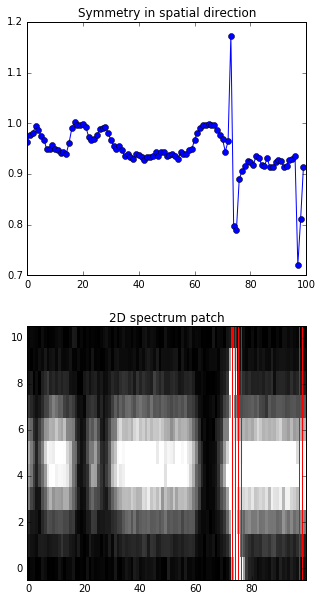

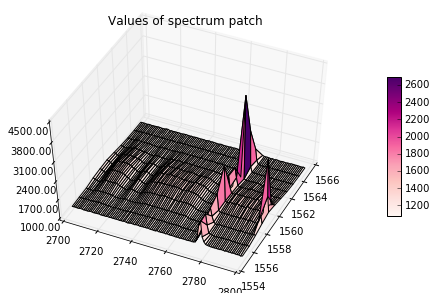

In [73]:
id_cosmic_rays(2700, 2800, 1555, 1566, .1)

Now we will be calling the function on a known emmission line to check that it doesn't create a false positive.

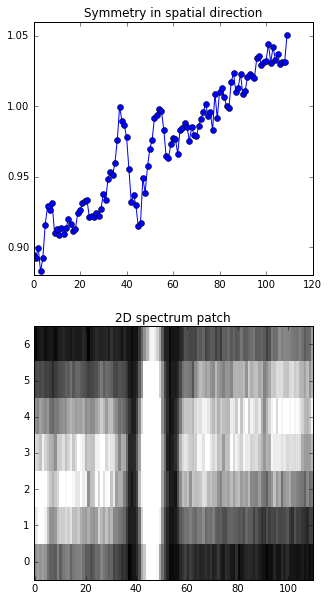

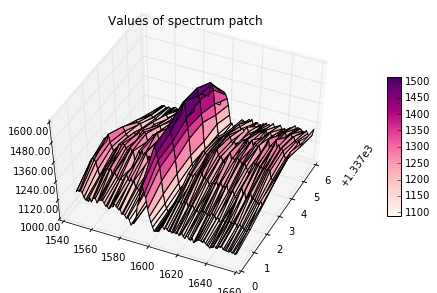

In [74]:
id_cosmic_rays(1550,1660,1337,1344,.15)

See, no cosmic rays.

In [75]:
#Get the polynomial file, breaks it up into an array

text = open('order_coefficients copy.txt', "r")
lines = text.read().splitlines()

coeff_array = np.zeros((79,5))

for i in range(len(lines)):
    a0 = float(lines[i][6:13].strip())
    a1 = float(lines[i][17:26].strip())
    a2 = float(lines[i][27:39].strip())
    a3 = float(lines[i][40:52].strip())
    a4 = float(lines[i][54:].strip())
    coeffs_one_line = np.array([a0,a1,a2,a3,a4])
    coeff_array[i] += coeffs_one_line
    

The following function cycles through all of the x values in a complete order of the spectrum, and at each x value takes a slice across the spectrum and evaluates it for symmetry. If it is non-symmetrical, then we'll flag it as containing a cosmic ray. 

In [76]:
def order_cosmic_ray(row, lim):

    x = np.arange(0, 4608).astype(float)

    y_values = np.zeros(4608)

    poly_reduced_image = np.zeros(4608)

    results = np.zeros(4608)
    cosmic_rays = 0

    a0 = coeff_array[row,0]
    a1 = coeff_array[row,1]
    a2 = coeff_array[row,2]
    a3 = coeff_array[row,3]
    a4 = coeff_array[row,4]
    for j in range(x.size):
        y = a0 + a1*x[j] + a2*x[j]**2 + a3*x[j]**3 + a4*x[j]**4
        y_values[j] = y
        y = int(round(y))
        poly_reduced_image[j] = int(np.sum(image_flip[y-3:y+4,j], axis = 0)-7*bias)
        results[j] = symmetry_check(j, int(y-3), int(y+3))

    plt.figure(figsize=(10,7))
    plt.subplot(2,1,1)
    plt.plot(poly_reduced_image)
    plt.subplot(2,1,2)
    plt.plot(results)

    for i in range(x.size):
        if np.absolute(results[i]-1) > lim:
            plt.axvline(x=i, linestyle = '--', color = 'r')

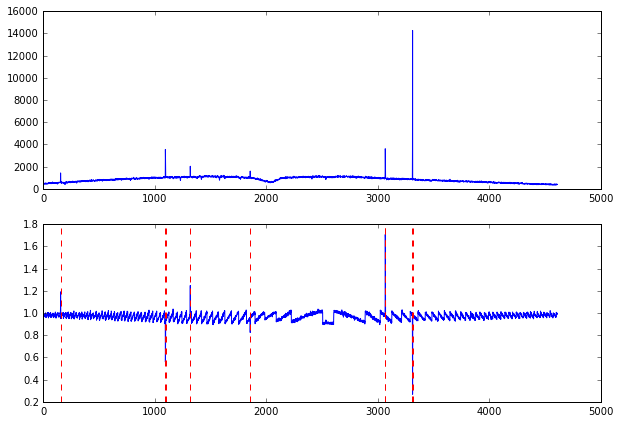

In [77]:
order_cosmic_ray(53, .15)